Notebook where GloVe vectors are used with a convolutional neural-net model

**Imports**

In [1]:

import json
import os
import pathlib
import pickle

import hyperopt
import pandas as pd
import keras
import numpy as np
import tensorflow as tf

import pyplotterlib.standard.plotters as ppl

import shared_code_path
import proc_pipes as procPipeHelp
import misc_utils as miscUtilHelp
import net_wrappers as netWrapHelp
import standard_pipes as stdPipeHelp


2023-04-25 11:42:14.109787: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-25 11:42:14.110983: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-25 11:42:14.134215: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-25 11:42:14.134759: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 11:42:14.503536: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

**Configuration Variables**

In [2]:

#
_rawDataFolder = os.path.abspath( os.path.join("..","..","..","raw_data") )
TRAIN_PATH = os.path.abspath( os.path.join(_rawDataFolder, "train.csv") )
TEST_PATH = os.path.abspath( os.path.join(_rawDataFolder, "test.csv") )
GLOVE_PATH = os.path.abspath( os.path.join(_rawDataFolder, "glove.twitter.27B.100d.txt")  )

#
SAVE_FOLDER = os.path.abspath( "glove_conv_net_save_folder" )
SUBMISSIONS_PATH = os.path.join(SAVE_FOLDER, "submissions.csv")

#280 was the CHARACTER limit at the time so 200 should easily be ok for recognised words
MAX_TEXT_LENGTH = 200
VOCAB_SIZE = 20000 #Theres about 17000 individual "words" from CountVectorizer; so this should be sufficient

#
RERUN_HP_SEARCH = False
GRID_SEARCH_NFILTERS = [64, 32, 16]
GRID_SEARCH_FILTER_LENGTHS = [4,5,6,7]
GRID_SEARCH_DROPOUT_FRACTS = [0.0, 0.2, 0.4, 0.6, 0.8]

#
RANDOM_SEED = 523423

In [3]:
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
keras.utils.set_random_seed(RANDOM_SEED)

**Create save folder**

In [4]:
pathlib.Path(SAVE_FOLDER).mkdir(exist_ok=True)

**Import GloVe vectors**

In [5]:
GLOVE_EMBED_DICT = miscUtilHelp.getGloveVectorsFromPath(GLOVE_PATH)

**Import raw data**

In [6]:
RAW_TRAIN = pd.read_csv(TRAIN_PATH)
RAW_TRAIN.head(2)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


**Apply a standard text cleaning pipeline**

In [7]:
cleanPipe = stdPipeHelp.loadTextPreprocPipeA()
PROC_DATA = cleanPipe.fit_transform(RAW_TRAIN)

**Shuffle the frame**

In [8]:
PROC_DATA = PROC_DATA.sample(frac=1.0)

In [9]:
PROC_DATA.head(2)

,id,keyword,location,text,target
663,958,blaze,Mo.City,@beautiful_juic1 just letting you know,0
2086,2998,dead,NaN,@atchisonsean he is dead,0


**Split into train/val data**

In [10]:
TRAIN_DATA = PROC_DATA.sample(frac=0.8)
VAL_DATA = PROC_DATA.drop(TRAIN_DATA.index)

**Add vocab indices to each frame**

In [11]:
vectorizerPipe = procPipeHelp.AddVectorizedColumns(VOCAB_SIZE, MAX_TEXT_LENGTH)
vectorizerPipe.fit(TRAIN_DATA)
TRAIN_DATA = vectorizerPipe.transform(TRAIN_DATA)
VAL_DATA = vectorizerPipe.transform(VAL_DATA)

In [12]:
TRAIN_DATA.head(2)

,id,keyword,location,text,target,vect_text_0,vect_text_1,vect_text_2,vect_text_3,vect_text_4,...,vect_text_190,vect_text_191,vect_text_192,vect_text_193,vect_text_194,vect_text_195,vect_text_196,vect_text_197,vect_text_198,vect_text_199
7471,10688,wreck,1/10 Taron squad,season three of new girl was such a emotional ...,0,875,108,7,56,446,...,0,0,0,0,0,0,0,0,0,0
6651,9529,terrorist,NaN,three israeli soldiers wounded in west bank te...,1,108,1039,1329,372,5,...,0,0,0,0,0,0,0,0,0,0


**Create the embedding layer**

In [13]:
_currArgs = [vectorizerPipe.vectorizer, GLOVE_EMBED_DICT, MAX_TEXT_LENGTH ]
EMBED_LAYER = netWrapHelp.createEmbedFixedLayer(*_currArgs)

**Run grid searches over a couple of parameters (dropout-fraction/convolutional filters/filter length)**

These are parameters related largely to the embedding/convolution part of our net architecture (rather than the hidden layers we MAY add). The architecture of our net can be found in the source code for the "SimpleConvNetFactoryA" function called below.

In [14]:
VECT_LENGTH = len( next(iter(GLOVE_EMBED_DICT.values()))  )
print("Using {} dimensional GloVe vectors".format(VECT_LENGTH))

Using 100 dimensional GloVe vectors


In [15]:

def fillInGridSearchScores(nFilters, printProgress=True, verbose=1):
    sharedArgs = [EMBED_LAYER, VECT_LENGTH, MAX_TEXT_LENGTH]
    _jobsLeft = len(GRID_SEARCH_DROPOUT_FRACTS)*len(GRID_SEARCH_FILTER_LENGTHS)
    for rIdx,dropoutFract in enumerate(GRID_SEARCH_DROPOUT_FRACTS):
        for cIdx,filterLength in enumerate(GRID_SEARCH_FILTER_LENGTHS):
            _currKwargs = {"dropoutFracts":[dropoutFract,0.0], "convNFilters":nFilters,
                           "convFilterLength":filterLength}
            currFactory = netWrapHelp.SimpleConvNetFactoryA(*sharedArgs, **_currKwargs)
            _useFeats = list() #We use prefixes to describe what features we actually use
            
            _currKwargs = {"featPrefix":["vect_text"], "verbose":verbose, "metrics":["acc"], "logitsOutput":False}
            netWrapper = netWrapHelp.BinaryNetWrapper( _useFeats, currFactory, SAVE_FOLDER, **_currKwargs)
            netWrapper.fit(TRAIN_DATA)
            currScore = netWrapper.score(VAL_DATA)
            GRID_SEARCH_SCORES[nFilters][rIdx][cIdx] = currScore
            _jobsLeft -= 1
            if printProgress:
                print("{} jobs left for nFilters={}".format(_jobsLeft,nFilters) )
            
    #Write to file
    outPath = _getOutPathFromNFilters(nFilters)
    with open(outPath,"wt") as f:
        json.dump(GRID_SEARCH_SCORES[nFilters].tolist(),f)
    

def _getOutPathFromNFilters(nFilters):
    return os.path.join(SAVE_FOLDER, "grid_search_nfilters_{}.json".format(nFilters) )

In [16]:
%%prun
#773377728 function calls (756755109 primitive calls) in 1248.162 seconds

_gridShape = ( len(GRID_SEARCH_DROPOUT_FRACTS), len(GRID_SEARCH_FILTER_LENGTHS) )
GRID_SEARCH_SCORES = { nFilters: np.zeros( _gridShape ) for nFilters in GRID_SEARCH_NFILTERS }

if RERUN_HP_SEARCH:
    for nFilters in GRID_SEARCH_NFILTERS:
        fillInGridSearchScores(nFilters)
else:
    for nFilters in GRID_SEARCH_SCORES.keys():
        currPath = _getOutPathFromNFilters(nFilters)
        with open(currPath,"rt") as f:
            GRID_SEARCH_SCORES[nFilters] = np.array(json.load(f))

**Visualize results of the grid search**

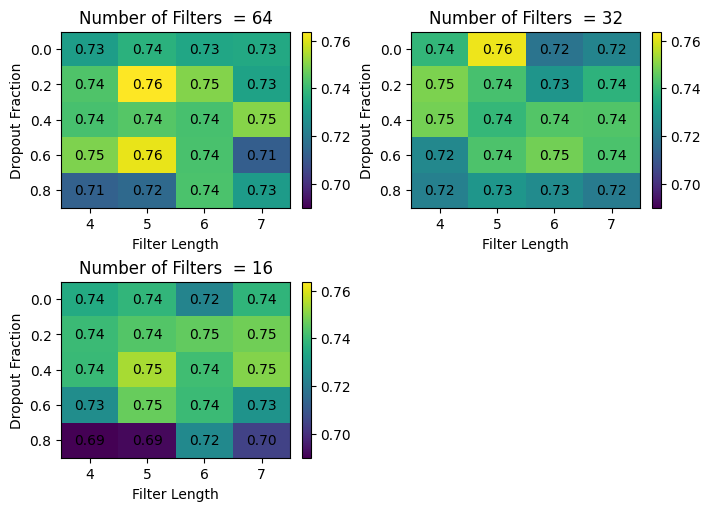

In [17]:
#Create a template heatmap plotter
_maxColor = max([np.max(x) for x in GRID_SEARCH_SCORES.values()])
_minColor = min([np.min(x) for x in GRID_SEARCH_SCORES.values()])
_currKwargs = {"annotateVals":True,
               "colorBarShow":True,
               "colorMapMaxVal":_maxColor,
               "colorMapMinVal":_minColor,
               "groupLabelsCols":GRID_SEARCH_FILTER_LENGTHS,
               "groupLabelsRows":GRID_SEARCH_DROPOUT_FRACTS,
               "xLabelStr":"Filter Length",
               "yLabelStr":"Dropout Fraction"
              }
heatmapTemplate = ppl.DiscreteHeatMapPlotter(**_currKwargs)


#Get individual discrete heat maps
plotters = list()
for nFilters,scores in GRID_SEARCH_SCORES.items():
    _titleStr = nFilters
    _currKwargs = {"plotData":scores, "titleStr":"Number of Filters  = {}".format(nFilters)}
    _currPlotter = heatmapTemplate.createFactory(**_currKwargs)
    plotters.append(_currPlotter)

#Remove y-axis label from all but one
    
#Plot heat maps in a grid
_currKwargs = {"constrainedLayout":True,
               "figHeightPerRow":2.5,
               "figWidthPerCol":3.5,
               "nColsGrid":2
               }
gridPlotter = ppl.RectMultiPlotter(**_currKwargs)

_unused = gridPlotter.createPlot(plotters=plotters)

**Conclusions:**

1) Not a huge dependence on any of the tested hyperparameters

2) Dropout fraction=0.8 is likely too large (which isnt massively surprising)

**Carry out a random search of hyperparameter space**

We have too many hyperparameters for grid search to be feasible. A random search is then more likely to find a reasonable point on the hypersurface since it allows exploration of more parameter values

In [18]:
#
_poolTypesA = ["average", "max"]
_poolTypesB = ["average", "max"]
_dropoutVals = [ [0.2,0.2], [0.2,0.4], [0.2,0.6],
                 [0.4,0.2], [0.4,0.4], [0.4,0.6] ]
_hiddenLayers = [None, [128,64,32], [64,32,16], [8,4] ]
_nFilters = [128, 96, 64, 32]
_convLength = [ 4,5,6 ]



searchSpaceDict = {"convNFilters": _nFilters,
                   "convFilterLength": _convLength,
                   "dropoutFracts":_dropoutVals,
                   "globPoolType": _poolTypesB,
                   "poolTypeA": _poolTypesA,
                   "hiddenLayerNodes":_hiddenLayers
                  }

searchSpace = {"convNFilters": hyperopt.hp.choice("convNFilters",_nFilters),
               "convFilterLength": hyperopt.hp.choice("convFilterLength",_convLength),
               "dropoutFracts":hyperopt.hp.choice("dropoutFracts", _dropoutVals),
               "globPoolType": hyperopt.hp.choice("globPoolType",_poolTypesB),
               "poolTypeA": hyperopt.hp.choice("poolTypeA", _poolTypesA),
               "hiddenLayerNodes": hyperopt.hp.choice("hiddenLayerNodes",_hiddenLayers)   }

_nPossible = 1
for val in searchSpaceDict.values():
    _nPossible *= len(val)

print("{} possible hyperparameter combinations in the search space".format(_nPossible))

1152 possible hyperparameter combinations in the search space


In [19]:
def calcScoreFromNetFactoryKwargs(searchSpace):
    #
    useKwargs = dict()
    useKwargs.update(searchSpace)
    
    #
    currFactory = netWrapHelp.SimpleConvNetFactoryA(EMBED_LAYER, VECT_LENGTH, MAX_TEXT_LENGTH, **useKwargs)
    
    netWrapper = netWrapHelp.BinaryNetWrapper( list(), currFactory, SAVE_FOLDER ,
                                               featPrefix=["vect_text"], verbose=0, metrics=["acc"],
                                               logitsOutput=False )
    netWrapper.fit(TRAIN_DATA)
    return -1*netWrapper.score(VAL_DATA)
    
    

In [20]:
%%prun
# 490091864 function calls (478875826 primitive calls) in 919.290 seconds

trials = hyperopt.Trials()

if RERUN_HP_SEARCH:
    best_hyperparams = hyperopt.fmin(fn = calcScoreFromNetFactoryKwargs,
                            space = searchSpace,
                            algo = hyperopt.tpe.suggest,
                            max_evals = 33,
                            trials = trials)

**Save or load the trials object**

In [21]:
trialsSavePath = os.path.join(SAVE_FOLDER, "trials.json")

if RERUN_HP_SEARCH:
    with open(trialsSavePath, 'wb') as f:
        pickle.dump(trials, f)
else:
    with open(trialsSavePath, 'rb') as f:
        trials = pickle.load(f)


**Print the best result from the random search**

In [22]:
trials.best_trial["result"]

{'loss': -0.7647610121836925, 'status': 'ok'}

In [23]:
[ print("{} = {}".format(key,searchSpaceDict[key][idx[0]])) for key,idx in trials.best_trial["misc"]["vals"].items()]

convFilterLength = 5
convNFilters = 128
dropoutFracts = [0.2, 0.6]
globPoolType = max
hiddenLayerNodes = [8, 4]
poolTypeA = max


[None, None, None, None, None, None]

**Create a new embed layer; fitted to the WHOLE dataset**

In [24]:
vectorizerPipeFinal = procPipeHelp.AddVectorizedColumns(VOCAB_SIZE, MAX_TEXT_LENGTH)
vectorizerPipeFinal.fit(PROC_DATA)
_currArgs = [vectorizerPipeFinal.vectorizer, GLOVE_EMBED_DICT, MAX_TEXT_LENGTH ]
EMBED_LAYER_FINAL = netWrapHelp.createEmbedFixedLayer(*_currArgs)

**Create a final model with the best hyperparameters**

In [25]:
#Deal with the net architecture
_currArgs = [ EMBED_LAYER_FINAL, VECT_LENGTH, MAX_TEXT_LENGTH]
_currKwargs = {"dropoutFracts":[0.2,0.6],
              "convNFilters":128,
              "convFilterLength":5,
              "poolTypeA":"max",
              "globPoolType":"max",
              "hiddenLayerNodes":[8,4]}
_modelFactory = netWrapHelp.SimpleConvNetFactoryA(*_currArgs, **_currKwargs)

#Deal with the interface to the net (and options on how to train it)
_feats = list() #We use featPrefix to get the features we need
_currArgs = [ _feats, _modelFactory, SAVE_FOLDER  ]
_currKwargs = {"featPrefix":["vect_text"], "verbose":1, "metrics":["acc"], "logitsOutput":False}
MODEL = netWrapHelp.BinaryNetWrapper(*_currArgs, **_currKwargs)

**Train the final model on the full dataset**

Really its trained on 80% of the data; using the other 20% to pick the best epoch

In [26]:
#Get a vectorized frame
VECT_FRAME = vectorizerPipeFinal.transform(PROC_DATA)
VECT_FRAME

,id,keyword,location,text,target,vect_text_0,vect_text_1,vect_text_2,vect_text_3,vect_text_4,...,vect_text_190,vect_text_191,vect_text_192,vect_text_193,vect_text_194,vect_text_195,vect_text_196,vect_text_197,vect_text_198,vect_text_199
663,958,blaze,Mo.City,@beautiful_juic1 just letting you know,0,16425,31,2902,10,87,...,0,0,0,0,0,0,0,0,0,0
2086,2998,dead,NaN,@atchisonsean he is dead,0,16679,49,9,114,0,...,0,0,0,0,0,0,0,0,0,0
2607,3742,destroyed,USA,black eye nine : a space battle occurred at st...,0,208,912,570,3,678,...,0,0,0,0,0,0,0,0,0,0
200,281,ambulance,VISIT MY YOUTUBE CHANNEL.,happening now - hatzolah ems ambulance respond...,0,1172,54,13132,2104,524,...,0,0,0,0,0,0,0,0,0,0
5661,8074,rescue,NaN,sammy and todd always to the rescue may not be...,0,9063,8,2662,244,4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1796,2576,crash,NaN,cpanel crash course #course,0,15219,97,723,723,0,...,0,0,0,0,0,0,0,0,0,0
4785,6808,loud%20bang,Kenya,tarmineta3 : breaking news ! unconfirmed ! i j...,0,7960,351,64,879,6,...,0,0,0,0,0,0,0,0,0,0
6644,9513,terrorist,"BILASPUR,CHHATTISGARH,495001",the pak terrorist who has been caught alive mu...,1,2,2014,377,68,50,...,0,0,0,0,0,0,0,0,0,0
12,18,NaN,NaN,#raining #flooding #florida #tampabay #tampa 1...,1,2781,207,1867,7975,2677,...,0,0,0,0,0,0,0,0,0,0


In [27]:
#
MODEL.fit(VECT_FRAME)

Epoch 1/10
172/175 [============================>.] - ETA: 0s - loss: 0.6017 - acc: 0.7102

2023-04-25 11:42:29.828088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,200,100]
	 [[{{node inputs}}]]
2023-04-25 11:42:29.834930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-25 11:42:30.762675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,200,100]
	 [[{{node inputs}}]]
2023-04-

INFO:tensorflow:Assets written to: /home/richard/Work/random/learning_ml/kaggle_comps/disaster_tweets_github/src/notebooks/models/glove_conv_net_save_folder/model_a/assets


INFO:tensorflow:Assets written to: /home/richard/Work/random/learning_ml/kaggle_comps/disaster_tweets_github/src/notebooks/models/glove_conv_net_save_folder/model_a/assets


175/175 [==============================] - 4s 21ms/step - loss: 0.6029 - acc: 0.7095 - val_loss: 0.4801 - val_acc: 0.7821
Epoch 2/10
173/175 [============================>.] - ETA: 0s - loss: 0.4825 - acc: 0.7822

2023-04-25 11:42:33.347225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,200,100]
	 [[{{node inputs}}]]
2023-04-25 11:42:33.354424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-25 11:42:34.298954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,200,100]
	 [[{{node inputs}}]]
2023-04-

INFO:tensorflow:Assets written to: /home/richard/Work/random/learning_ml/kaggle_comps/disaster_tweets_github/src/notebooks/models/glove_conv_net_save_folder/model_a/assets


INFO:tensorflow:Assets written to: /home/richard/Work/random/learning_ml/kaggle_comps/disaster_tweets_github/src/notebooks/models/glove_conv_net_save_folder/model_a/assets


175/175 [==============================] - 4s 20ms/step - loss: 0.4816 - acc: 0.7826 - val_loss: 0.4732 - val_acc: 0.7943
Epoch 3/10
173/175 [============================>.] - ETA: 0s - loss: 0.4504 - acc: 0.7941

2023-04-25 11:42:36.861894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,200,100]
	 [[{{node inputs}}]]
2023-04-25 11:42:36.868701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-25 11:42:37.703989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,200,100]
	 [[{{node inputs}}]]
2023-04-

INFO:tensorflow:Assets written to: /home/richard/Work/random/learning_ml/kaggle_comps/disaster_tweets_github/src/notebooks/models/glove_conv_net_save_folder/model_a/assets


INFO:tensorflow:Assets written to: /home/richard/Work/random/learning_ml/kaggle_comps/disaster_tweets_github/src/notebooks/models/glove_conv_net_save_folder/model_a/assets


175/175 [==============================] - 3s 20ms/step - loss: 0.4503 - acc: 0.7939 - val_loss: 0.4688 - val_acc: 0.7978
Epoch 4/10
172/175 [============================>.] - ETA: 0s - loss: 0.4185 - acc: 0.8129

2023-04-25 11:42:40.386632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,200,100]
	 [[{{node inputs}}]]
2023-04-25 11:42:40.393402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-25 11:42:41.233949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,200,100]
	 [[{{node inputs}}]]
2023-04-

INFO:tensorflow:Assets written to: /home/richard/Work/random/learning_ml/kaggle_comps/disaster_tweets_github/src/notebooks/models/glove_conv_net_save_folder/model_a/assets


INFO:tensorflow:Assets written to: /home/richard/Work/random/learning_ml/kaggle_comps/disaster_tweets_github/src/notebooks/models/glove_conv_net_save_folder/model_a/assets


175/175 [==============================] - 4s 20ms/step - loss: 0.4184 - acc: 0.8134 - val_loss: 0.4644 - val_acc: 0.8007
Epoch 5/10
168/175 [===========================>..] - ETA: 0s - loss: 0.4124 - acc: 0.8129

2023-04-25 11:42:43.886899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,200,100]
	 [[{{node inputs}}]]
2023-04-25 11:42:43.893434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-25 11:42:44.719084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,200,100]
	 [[{{node inputs}}]]
2023-04-

INFO:tensorflow:Assets written to: /home/richard/Work/random/learning_ml/kaggle_comps/disaster_tweets_github/src/notebooks/models/glove_conv_net_save_folder/model_a/assets


INFO:tensorflow:Assets written to: /home/richard/Work/random/learning_ml/kaggle_comps/disaster_tweets_github/src/notebooks/models/glove_conv_net_save_folder/model_a/assets


175/175 [==============================] - 3s 20ms/step - loss: 0.4115 - acc: 0.8142 - val_loss: 0.4628 - val_acc: 0.8007
Epoch 6/10
175/175 [==============================] - 1s 9ms/step - loss: 0.3966 - acc: 0.8299 - val_loss: 0.4711 - val_acc: 0.7957
Epoch 7/10
169/175 [===========================>..] - ETA: 0s - loss: 0.3875 - acc: 0.8349

2023-04-25 11:42:48.826038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,200,100]
	 [[{{node inputs}}]]
2023-04-25 11:42:48.832927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-25 11:42:49.658644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,200,100]
	 [[{{node inputs}}]]
2023-04-

INFO:tensorflow:Assets written to: /home/richard/Work/random/learning_ml/kaggle_comps/disaster_tweets_github/src/notebooks/models/glove_conv_net_save_folder/model_a/assets


INFO:tensorflow:Assets written to: /home/richard/Work/random/learning_ml/kaggle_comps/disaster_tweets_github/src/notebooks/models/glove_conv_net_save_folder/model_a/assets


175/175 [==============================] - 3s 19ms/step - loss: 0.3877 - acc: 0.8351 - val_loss: 0.4581 - val_acc: 0.8065
Epoch 8/10
171/175 [============================>.] - ETA: 0s - loss: 0.3738 - acc: 0.8352

2023-04-25 11:42:52.221994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,200,100]
	 [[{{node inputs}}]]
2023-04-25 11:42:52.229322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-25 11:42:53.156933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,200,100]
	 [[{{node inputs}}]]
2023-04-

INFO:tensorflow:Assets written to: /home/richard/Work/random/learning_ml/kaggle_comps/disaster_tweets_github/src/notebooks/models/glove_conv_net_save_folder/model_a/assets


INFO:tensorflow:Assets written to: /home/richard/Work/random/learning_ml/kaggle_comps/disaster_tweets_github/src/notebooks/models/glove_conv_net_save_folder/model_a/assets


175/175 [==============================] - 4s 20ms/step - loss: 0.3752 - acc: 0.8349 - val_loss: 0.4576 - val_acc: 0.8029
Epoch 9/10
175/175 [==============================] - 2s 9ms/step - loss: 0.3645 - acc: 0.8380 - val_loss: 0.4636 - val_acc: 0.8029
Epoch 10/10
175/175 [==============================] - 2s 9ms/step - loss: 0.3518 - acc: 0.8493 - val_loss: 0.4628 - val_acc: 0.8057


BinaryNetWrapper(featPrefix=['vect_text'], feats=[], logitsOutput=False,
                 metrics=['acc'],
                 netCreator=<net_wrappers.SimpleConvNetFactoryA object at 0x7f1108628ac0>,
                 saveFolder='/home/richard/Work/random/learning_ml/kaggle_comps/disaster_tweets_github/src/notebooks/models/glove_conv_net_save_folder',
                 verbose=1)

**Quickly check our training accuracy is reasonable**

In [28]:
trainPred = MODEL.predict(VECT_FRAME)
_deltaVals = [ abs(pred-act) for pred,act in zip(trainPred,VECT_FRAME["target"].to_numpy()) ]
trainAcc = (len(_deltaVals)-sum(_deltaVals)) / len(_deltaVals)
print("Training accuracy = {}".format(trainAcc))

218/218 [==============================] - 1s 3ms/step
Training accuracy = 0.8781362007168458


**Apply the model to the test data set**

In [29]:
RAW_TEST = pd.read_csv(TEST_PATH)
RAW_TEST.head(2)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."


In [30]:
testCleanPipe = stdPipeHelp.loadTextPreprocPipeA(removeDuplicateTweets=False)
testCleanPipe.fit(RAW_TRAIN)

#
PROC_TEST = testCleanPipe.transform(RAW_TEST)
PROC_TEST = vectorizerPipeFinal.transform(PROC_TEST)
PROC_TEST["target"] = MODEL.predict(PROC_TEST)
PROC_TEST[["id","text","target"]].head(8)

102/102 [==============================] - 0s 3ms/step


,id,text,target
0,0,just happened a terrible car crash,1
1,2,"heard about #earthquake is different cities , ...",1
2,3,"there is a forest fire at spot pond , geese ar...",1
3,9,apocalypse lighting . #spokane #wildfires,1
4,11,typhoon soudelor kills 28 in china and taiwan,1
5,12,we are shaking . it is an earthquake,1
6,21,they ' d probably still show more life than ar...,0
7,22,hey ! how are you ?,0


**Write our predictions to file in the correct format**

Kaggle Score - 0.80631 (RERUN_HP_SEARCH=True)

Kaggle Score - 0.80815 (RERUN_HP_SEARCH=False)

The differences in scores are because i didnt reset the relevant random number generators between tuning hyperparameters and training the final model

In [31]:
outFrame = PROC_TEST[["id","target"]]
outFrame.to_csv(SUBMISSIONS_PATH, index=False)

In [32]:
outFrame

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
